# HW 5

By: Steven Jia with Quentin Phillips

In [2]:
!pip install usearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.8 MB/s eta 0:00:00


In [11]:
!pip install fastkde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.3 MB/s eta 0:00:00


In [18]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from usearch.index import search, MetricKind, Matches, BatchMatches
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import fastkde
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report as CR

In [110]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0)

In [111]:
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


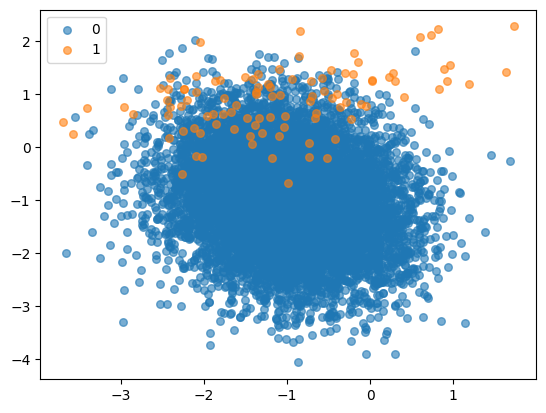

In [112]:
for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label),alpha=0.6,s=30)
plt.legend()
plt.show()

## KNN Class

In [113]:
class Nearest_Neighbors:
  def __init__(self, X, y, k=10):
    self.classification = y
    self.vectors = X
    self.k = k
    self.output = []

  def predict(self, x_new):
    output: Matches = search(self.vectors, x_new, self.k, MetricKind.L2sq, exact=True)
    prediction = []
    for out in output:
      nearest = self.classification[out.keys]
      counts = Counter(nearest)
      prediction.append(max(counts, key=counts.get))
    return prediction

## SMOTE

Counter({0: 9900, 1: 9900})


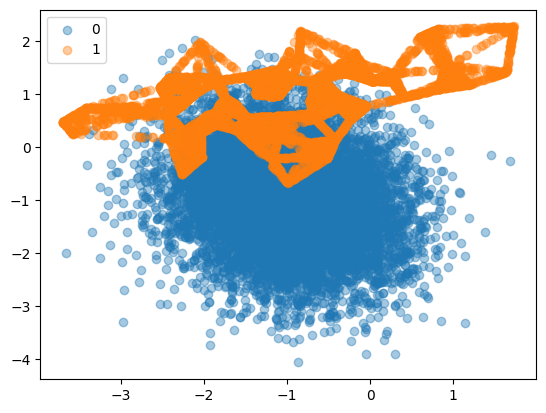

In [114]:
oversample = SMOTE()
Xs, ys = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(ys)
print(counter)
for label, _ in counter.items():
	row_ix = np.where(ys == label)[0]
	plt.scatter(Xs[row_ix, 0], Xs[row_ix, 1], label=str(label),alpha=0.4)
plt.legend()
plt.show()

In [115]:
msa = []
kf = KFold(n_splits=5,shuffle=True,random_state=1234)

for idxtrain, idxtest in kf.split(Xs):
  xtrain = Xs[idxtrain]
  ytrain = ys[idxtrain].ravel()
  ytest = ys[idxtest].ravel()
  xtest = Xs[idxtest]
  model = Nearest_Neighbors(xtrain, ytrain, k = 5)
  result = CR(ytest,model.predict(xtest), output_dict = True)
  msa.append(result['0']['precision'])

In [116]:
print(np.mean(msa))

0.9720695772061824


## ADASYN

Counter({1: 9908, 0: 9900})


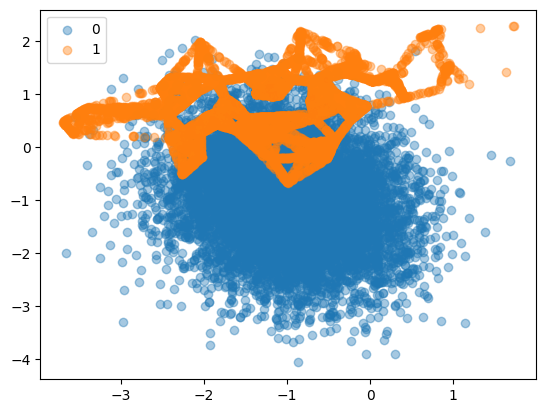

In [117]:
ada = ADASYN(random_state=42)
Xa, ya = ada.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(ya)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(ya == label)[0]
	plt.scatter(Xa[row_ix, 0], Xa[row_ix, 1], label=str(label),alpha=0.4)
plt.legend()
plt.show()

In [118]:
msa = []
kf = KFold(n_splits=5,shuffle=True,random_state=1234)

for idxtrain, idxtest in kf.split(Xa):
  xtrain = Xa[idxtrain]
  ytrain = ya[idxtrain].ravel()
  ytest = ya[idxtest].ravel()
  xtest = Xa[idxtest]
  model = Nearest_Neighbors(xtrain, ytrain, k = 8)
  result = CR(ytest,model.predict(xtest), output_dict = True)
  msa.append(result['0']['precision'])

In [119]:
print(np.mean(msa))

0.9768165867447285


## FastKDE

In [120]:
minority_features = X[y==1]
lb = minority_features.min(axis=0)
ub = minority_features.max(axis=0)
testpoints = np.random.uniform(low=lb,high=ub, size=(10000,2))
pdf = fastkde.pdf_at_points(minority_features[:,0],minority_features[:,1],list_of_points=testpoints,num_points=2**9+1)

In [121]:
fakes = testpoints[pdf>np.percentile(pdf,65)]

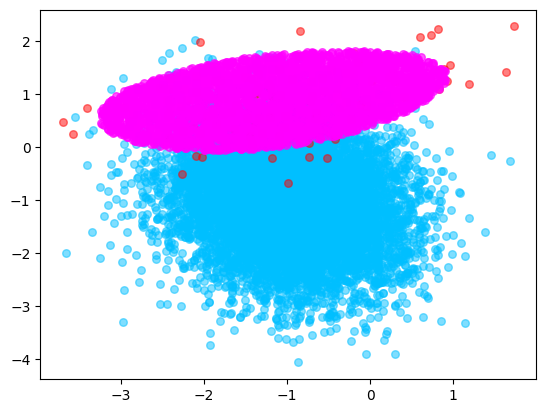

In [122]:
plt.scatter(X[y==0,0],X[y==0,1],color='DeepSkyBlue',s=30,alpha=0.5)
plt.scatter(X[y==1,0],X[y==1,1],color='red',s=30,alpha=0.5)
plt.scatter(fakes[:,0],fakes[:,1],color='magenta',s=30,alpha=0.65)
plt.show()

In [123]:
Xk = np.row_stack([X,fakes])
yk = np.concatenate([y,np.ones(len(fakes))]).astype(int)

In [124]:
msa = []
kf = KFold(n_splits=5,shuffle=True,random_state=1234)

for idxtrain, idxtest in kf.split(Xk):
  xtrain = Xk[idxtrain]
  ytrain = yk[idxtrain].ravel()
  ytest = yk[idxtest].ravel()
  xtest = Xk[idxtest]
  model = Nearest_Neighbors(xtrain, ytrain, k = 12)
  result = CR(ytest,model.predict(xtest), output_dict = True)
  msa.append(result['0']['precision'])

In [125]:
print(np.mean(msa))

0.9565356331455532


Overall it seems that fastkde is has the lowest accuracy, however all three methods consistently score above 90% accuracy.